In [85]:
# Dataset testing

import h5py
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.fft as fft
import sigpy
import pynufft
import skimage
import os
import multiprocessing as mp
from multiprocessing import Pool
from PIL import Image
import tqdm
import glob

from training.dataset import *
from dnnlib.util import *
from torch_utils import distributed as dist
from torch_utils import misc
import training.trajectory as trajectory
import training.visualize as visualize
import generate_conditional

device = torch.device('cuda')

import torchvision

import time

In [95]:
# Load dataset.
seeds = [0,]
dataset_kwargs = dnnlib.EasyDict(class_name='training.dataset.NonCartesianDataset', path='../fastMRIprocessing/data_64_multicoil_mini', use_labels=False, xflip=False, fetch_raw=True, undersampling=0.9, interleaves=(4,20))
data_loader_kwargs = dnnlib.EasyDict(pin_memory=True, num_workers=1, prefetch_factor=2)
dist.print0('Loading dataset...')
dataset_obj = dnnlib.util.construct_class_by_name(**dataset_kwargs) # subclass of training.dataset.Dataset
dataset_sampler = misc.InfiniteSampler(dataset=dataset_obj, rank=dist.get_rank(), num_replicas=dist.get_world_size(), seed=seeds[0])
dataset_iterator = iter(torch.utils.data.DataLoader(dataset=dataset_obj, sampler=dataset_sampler, batch_size=1, **data_loader_kwargs))

Loading dataset...


In [101]:
start = time.time()

parcel = next(dataset_iterator)

end = time.time()
print(end - start)

0.00033926963806152344


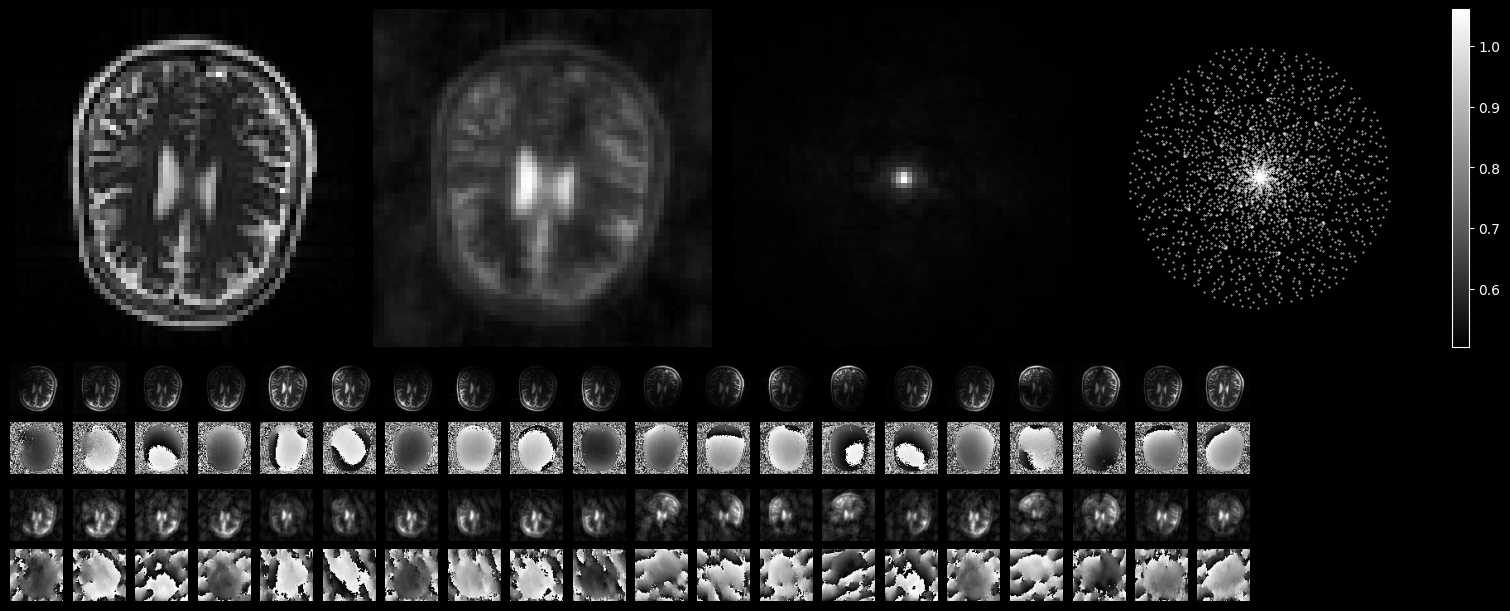

In [102]:
visualize.show_data_parcel(parcel)

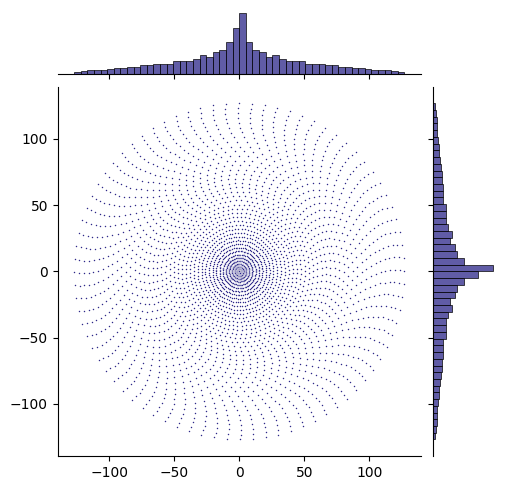

In [103]:
trajectory.plot_trajectory(trajectory.make_trajectory((256,256), undersampling=0.05, interleaves=80, alpha=3))

In [104]:
256**2/3360

19.504761904761907

In [105]:
trajectory.make_trajectory((256,256), undersampling=0.05, interleaves=80, alpha=3).shape

(3360, 2)

# nufft

    image --forward_nufft-->   kspace       --inverse_nufft-->  image


    image --forward_nufft-->   kspace_pred  --inverse_nufft-->  image

                                    -
                        
                              known kspace                         +

                                    ||
                          
                              delta kspace  --nufft_inverse--> delta image

                                                                   ||
                                                          
                                                                image next 



In [106]:
image = trajectory.float_to_complex(parcel[0])
points = np.array(parcel[3]['points'])
image_pil = visualize.tensor_to_image(torch.tensor(trajectory.root_summed_squares(image)).unsqueeze(0), normalize=False)

# Generate a fake image to use as a x_t image
blur = torchvision.transforms.GaussianBlur(25)
fake = np.array(blur(torch.Tensor(image)), dtype = np.complex64)
fake_pil = visualize.tensor_to_image(torch.tensor(trajectory.root_summed_squares(fake)).unsqueeze(0), normalize=False)

nufftobj = trajectory.prealloc_nufft(image[0], points[0])
y = trajectory.forward_nufft(image[0], nufftobj)
x = trajectory.inverse_nufft(y, nufftobj)
image_recon_pil = visualize.tensor_to_image(torch.tensor(trajectory.root_summed_squares(x)).unsqueeze(0).unsqueeze(0), normalize=False)

y_prime = trajectory.forward_nufft(fake[0], nufftobj)
x_prime = trajectory.inverse_nufft(y_prime, nufftobj)
fake_recon_pil = visualize.tensor_to_image(torch.tensor(trajectory.root_summed_squares(x_prime)).unsqueeze(0).unsqueeze(0), normalize=False)

residual = trajectory.inverse_nufft(y-y_prime, nufftobj)
residual_pil = visualize.tensor_to_image(torch.tensor(trajectory.root_summed_squares(residual)).unsqueeze(0).unsqueeze(0), normalize=False)


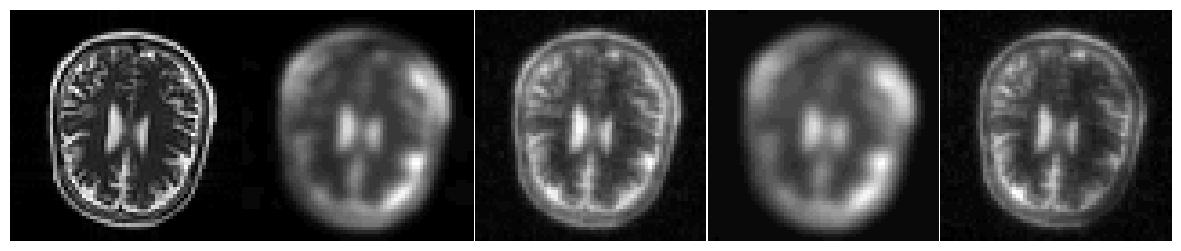

In [107]:
visualize.image_array((image_pil, fake_pil, image_recon_pil, fake_recon_pil, residual_pil), columns=5)

In [81]:
a = torch.ones(3) + torch.ones(3)*1j

In [82]:
a

tensor([1.+1.j, 1.+1.j, 1.+1.j])

In [84]:
torch.max(a)

RuntimeError: "max_values_cpu" not implemented for 'ComplexFloat'